In [5]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch import nn
from torchvision import models, transforms

In [ ]:
def showGradMap(path, class_name):
    read_tensor = transforms.Compose([
        lambda x: Image.open(x),
        lambda x: x.convert('RGB'),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
        lambda x: torch.unsqueeze(x, 0)
    ])

    class Flatten(nn.Module):
        """One layer module that flattens its input."""
        def __init__(self):
            super(Flatten, self).__init__()
        def forward(self, x):
            return x.view(x.size(0), -1)

 
    model = torch.load('./models/DenseNet161/densenet161.pth')
    model = model.eval()

    
    features_fn = model.features
    classifier_fn = nn.Sequential(*([nn.AvgPool2d(7, 1), Flatten()] + [model.classifier]))

    
    def GradCAM(img, c, features_fn, classifier_fn):
        feats = features_fn(img)
        _, N, H, W = feats.size()
        out = classifier_fn(feats)
        c_score = out[0, c]
        grads = torch.autograd.grad(c_score, feats)
        w = grads[0][0].mean(-1).mean(-1)
        sal = torch.matmul(w, feats.view(N, H*W))
        sal = sal.view(H, W).detach().numpy()
        sal = np.maximum(sal, 0)
        return sal

 
    img_tensor = read_tensor(path)

   
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()

    print(predicted_class)

    
 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.axis('off')


    original_img = Image.open(path)
    axes[0].imshow(original_img)
    axes[0].set_title(f'Original Image ({class_name})')

 
    sal = GradCAM(img_tensor, predicted_class, features_fn, classifier_fn)
    sal_img = Image.fromarray(sal)
    sal_img = sal_img.resize(original_img.size, resample=Image.BILINEAR)
    axes[1].imshow(original_img)
    axes[1].imshow(np.array(sal_img), alpha=0.31, cmap='jet')
    axes[1].set_title('Grad-CAM')

    plt.subplots_adjust(wspace=0.1) 
    plt.show()





0


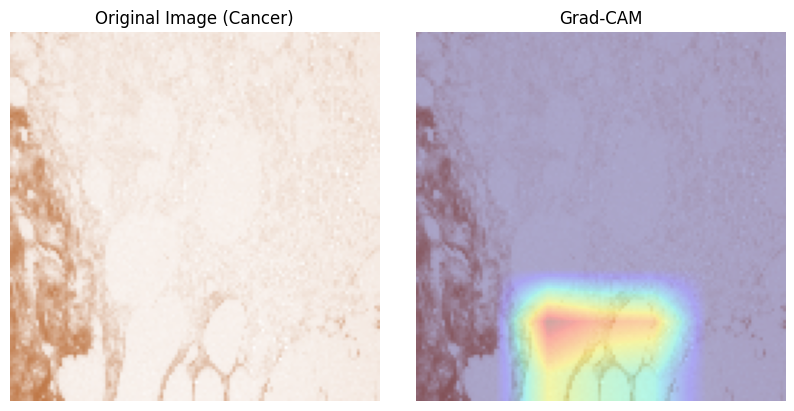

In [9]:

showGradMap('./Dataset/CANCER/10389 (2).png','Cancer')


0


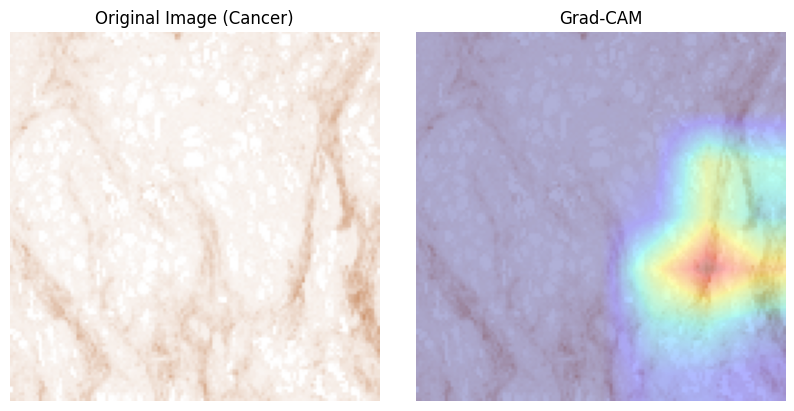

In [10]:
showGradMap('./Dataset/CANCER/10389 (3).png','Cancer')

In [23]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


model = torch.load('./modelss/denseNet161_adam.pth')
model.eval()  

class_labels = ['healthy', 'cancer']

def predict_image(image_path):

    image = Image.open(image_path).convert('RGB')  
    image = transform(image) 
    image = image.unsqueeze(0)  

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_labels[predicted.item()]

    return predicted_class

image_path = './Dataset/CANCER/10389 (10).png'
predicted_class = predict_image(image_path)
print(f'The predicted class for the image is: {predicted_class}')


The predicted class for the image is: healthy
